# Chapter 17 exercise 9

## _Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## TensorFlow Tutorial version

In [2]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

print(X_train.shape)

(60000, 28, 28, 1)


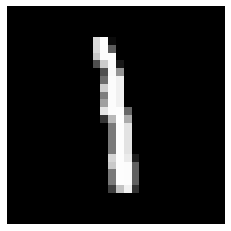

In [4]:
plt.imshow(tf.squeeze(X_test[29]), cmap='gray')
plt.axis("off")
plt.show()

In [5]:
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape) 
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape) 

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)

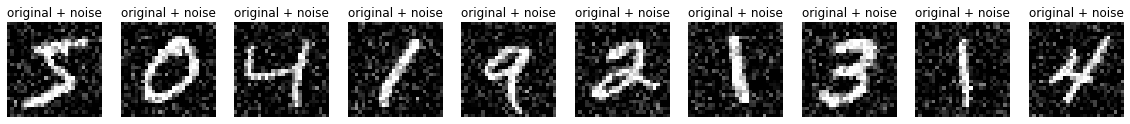

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_train_noisy[i]), cmap='binary')
    plt.axis("off")
    plt.gray()
plt.show()

In [7]:
class Denoise(keras.models.Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      keras.layers.Input(shape=(28, 28, 1)),
      keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      keras.layers.Conv2D(1, kernel_size=(3, 3), activation='relu', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [8]:
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [9]:
autoencoder.fit(X_train_noisy, X_train,
                epochs=3,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

Epoch 1/3
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 2/3
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 3/3
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0034 - val_loss: 0.0033


In [12]:
encoded_imgs = autoencoder.encoder(X_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

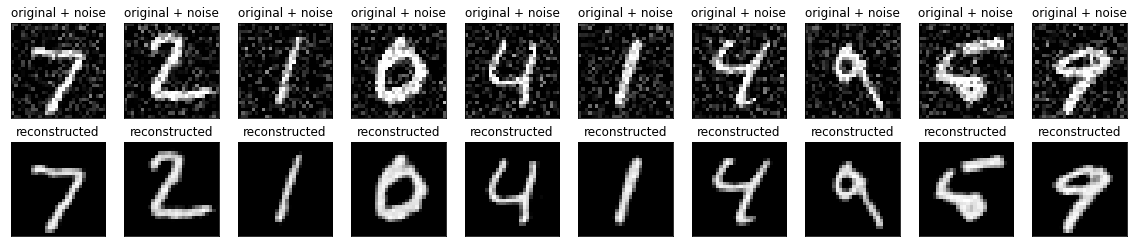

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Book solution

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[28,28,1]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(28*28, activation="relu", input_shape=[512]),
    keras.layers.Reshape([28,28,1]),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, 
                                 padding="same", activation="sigmoid")
])

For Reshape need to make sure 3d for Conv2D transpose.  
Filters need to be 1 since it is a Black & White image

In [32]:
denoising_encoder.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_8 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               3211776   
Total params: 3,212,096
Trainable params: 3,212,096
Non-trainable params: 0
_________________________________________________________________


In [33]:
denoising_decoder.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 784)               402192    
_________________________________________________________________
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 1)         10        
Total params: 402,202
Trainable params: 402,202
Non-trainable params: 0
_________________________________________________________________


In [35]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=3,
                           validation_data=(X_test, X_test))

Epoch 1/3
1875/1875 [==============================] - 132s 70ms/step - loss: 0.1245 - mse: 0.0221 - val_loss: 0.1284 - val_mse: 0.0233
Epoch 2/3
1875/1875 [==============================] - 131s 70ms/step - loss: 0.1212 - mse: 0.0208 - val_loss: 0.1265 - val_mse: 0.0226
Epoch 3/3
1875/1875 [==============================] - 134s 71ms/step - loss: 0.1204 - mse: 0.0206 - val_loss: 0.1242 - val_mse: 0.0218


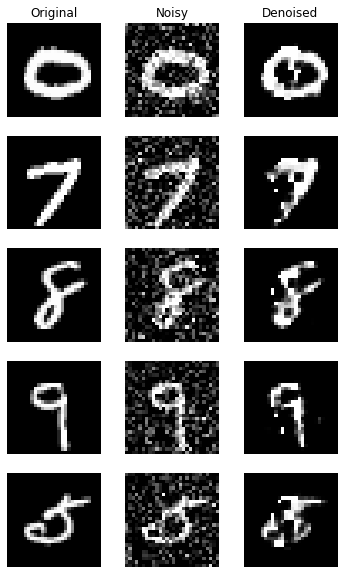

In [58]:
n_images = 5
sample = np.random.choice(X_test.shape[0], n_images)
new_images = X_test[sample]
new_images_noisy = new_images + np.random.randn(n_images, 28, 28, 1) * 0.3
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index].squeeze())
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index].squeeze(), 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index].squeeze())
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

## Testing autoencoder capacity

Reload the MNIST dataset

In [60]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [61]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [64]:
X_train_set = X_train[:50000]
X_valid_set = X_train[50000:]

In [82]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(36, activation="relu"),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[36]),
    keras.layers.Dense(784, activation="relu"),
    keras.layers.Reshape([28, 28])
])

autoencoder = keras.models.Sequential([encoder, decoder])

opt = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

n_epochs = 10
history = autoencoder.fit(X_train_set, X_train_set, epochs=n_epochs, batch_size=32, validation_data=(X_valid_set, X_valid_set))


Epoch 1/10
1563/1563 [==============================] - 2s 953us/step - loss: 0.0486 - val_loss: 0.0340
Epoch 2/10
1563/1563 [==============================] - 1s 924us/step - loss: 0.0303 - val_loss: 0.0278
Epoch 3/10
1563/1563 [==============================] - 1s 913us/step - loss: 0.0262 - val_loss: 0.0251
Epoch 4/10
1563/1563 [==============================] - 1s 914us/step - loss: 0.0245 - val_loss: 0.0239
Epoch 5/10
1563/1563 [==============================] - 1s 927us/step - loss: 0.0238 - val_loss: 0.0235
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 7/10
1563/1563 [==============================] - 2s 986us/step - loss: 0.0225 - val_loss: 0.0224
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0218 - val_loss: 0.0218
Epoch 9/10
1563/1563 [==============================] - 2s 972us/step - loss: 0.0212 - val_loss: 0.0207
Epoch 10/10
1563/1563 [==============================] - 2s 988us/st

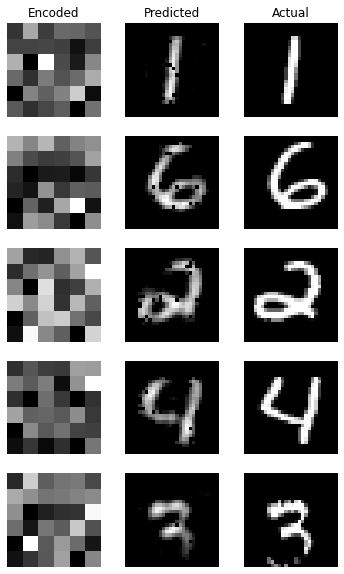

In [84]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_images = 5
sample = np.random.choice(X_test.shape[0], n_images)
test_images = X_test[sample]
test_images_encoded = encoder.predict(test_images)
test_images_predict = autoencoder.predict(test_images)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(test_images_encoded[index].reshape([6,6]))
    plt.axis('off')
    if index == 0:
        plt.title("Encoded")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(test_images_predict[index].squeeze())
    plt.axis('off')
    if index == 0:
        plt.title("Predicted")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(test_images[index].squeeze())
    plt.axis('off')
    if index == 0:
        plt.title("Actual")
plt.show()

In [85]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

info_shape=25

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(info_shape, activation="relu"),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(784, activation="relu", input_shape=[info_shape]),
    keras.layers.Reshape([28, 28])
])

autoencoder = keras.models.Sequential([encoder, decoder])

opt = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

n_epochs = 10
history = autoencoder.fit(X_train_set, X_train_set, epochs=n_epochs, batch_size=32, validation_data=(X_valid_set, X_valid_set))


Epoch 1/10
1563/1563 [==============================] - 1s 786us/step - loss: 0.0473 - val_loss: 0.0332
Epoch 2/10
1563/1563 [==============================] - 1s 784us/step - loss: 0.0305 - val_loss: 0.0282
Epoch 3/10
1563/1563 [==============================] - 1s 773us/step - loss: 0.0276 - val_loss: 0.0267
Epoch 4/10
1563/1563 [==============================] - 1s 764us/step - loss: 0.0267 - val_loss: 0.0260
Epoch 5/10
1563/1563 [==============================] - 1s 770us/step - loss: 0.0260 - val_loss: 0.0249
Epoch 6/10
1563/1563 [==============================] - 1s 746us/step - loss: 0.0251 - val_loss: 0.0246
Epoch 7/10
1563/1563 [==============================] - 1s 761us/step - loss: 0.0246 - val_loss: 0.0242
Epoch 8/10
1563/1563 [==============================] - 1s 817us/step - loss: 0.0244 - val_loss: 0.0241
Epoch 9/10
1563/1563 [==============================] - 1s 779us/step - loss: 0.0243 - val_loss: 0.0238
Epoch 10/10
1563/1563 [==============================] - 1s 787u

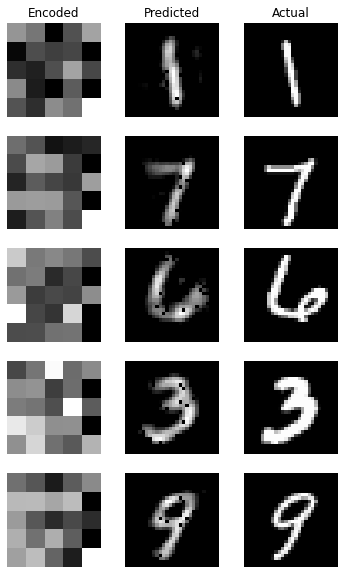

In [92]:
keras.backend.clear_session()
tf.random.set_seed(123)
np.random.seed(123)

info_reshape = [np.sqrt(info_shape).astype(int),]*2

n_images = 5
sample = np.random.choice(X_test.shape[0], n_images)
test_images = X_test[sample]
test_images_encoded = encoder.predict(test_images)
test_images_predict = autoencoder.predict(test_images)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(test_images_encoded[index].reshape(info_reshape))
    plt.axis('off')
    if index == 0:
        plt.title("Encoded")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(test_images_predict[index].squeeze())
    plt.axis('off')
    if index == 0:
        plt.title("Predicted")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(test_images[index].squeeze())
    plt.axis('off')
    if index == 0:
        plt.title("Actual")
plt.show()